In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import scipy.stats as st
import scipy
import sklearn
import statsmodels
from math import sqrt

sns.set()

/Users/immanuel4n/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
df=pd.read_pickle('ss_totglob.pkl')

In [3]:
df.head(3)

Date
2014-01-01    234724.0
2014-02-01    253304.0
2014-03-01    416629.0
Name: Net Inv Qty, dtype: float64

In [4]:
#Summary Statistics

df.describe()

count        60.000000
mean     419379.133333
std      174857.092662
min      169401.000000
25%      291368.000000
50%      386906.500000
75%      529386.500000
max      905683.000000
Name: Net Inv Qty, dtype: float64

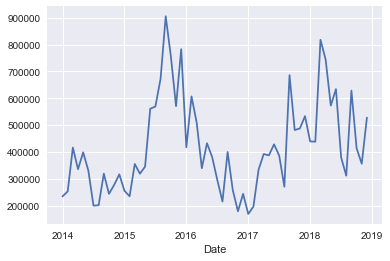

In [5]:
# Line plots
df.plot();plt.show()

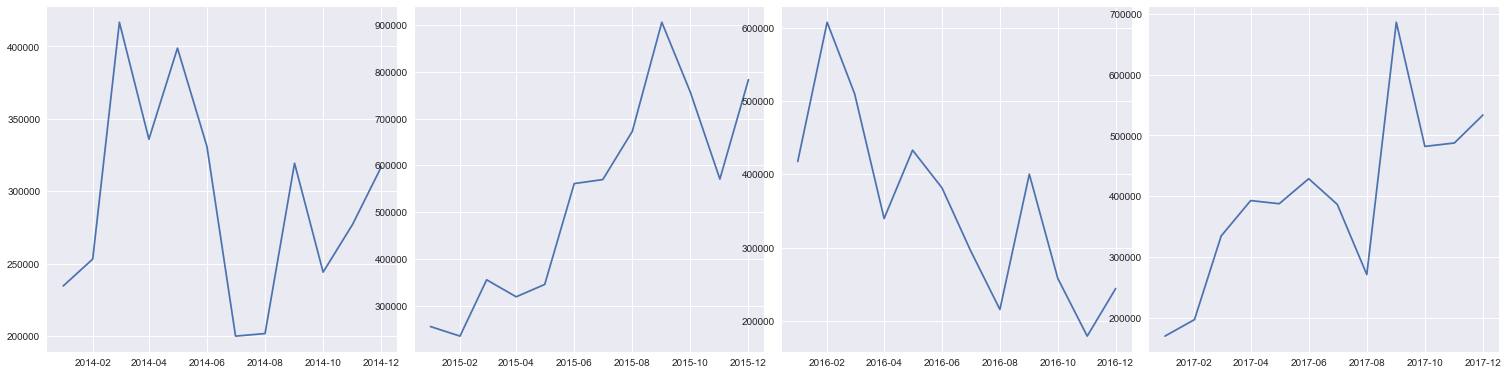

In [6]:
# yearly Line plots

groups = df['2014':'2017'].groupby(pd.Grouper(freq='A'))
years = pd.DataFrame()

grp=[]
for name, group in groups:
    grp.append(group)
    years[name.year] = group.values



plt.figure(figsize=(9 * 2 + 3, 5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,hspace=.01)

n_groups = len(groups)
for i in range(1,n_groups+1):
    if i ==1:
        plt.subplot(1,4,i)
        plt.plot(grp[i-1])
    else:
        plt.subplot(1,4,i)
        plt.plot(grp[i-1])
        
plt.show()

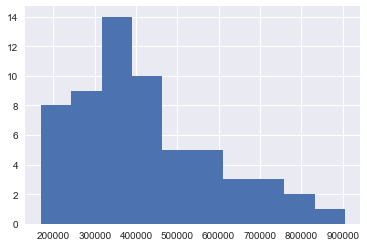

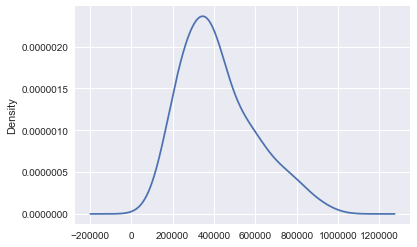

In [7]:
#Density plot

df.hist()
plt.show()
df.plot(kind='kde')
plt.show()

The distribution looks to be right skewed.

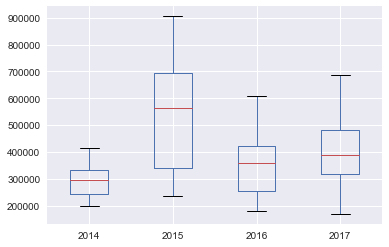

In [8]:
#Box and Whisker Plots
years.boxplot(); plt.show()

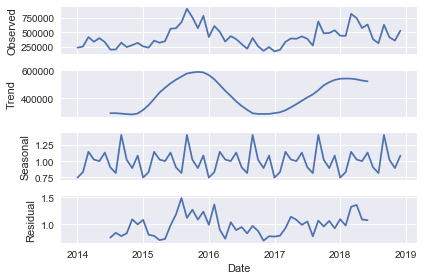

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df, model='multiplicative')
result.plot()
plt.show()

In [10]:
# Split data into training and validation samples

split_size = len(df) - 12 # set aside the last year as the validation sample
reduced_dataset, validation_dataset = df[0:split_size], df[split_size:]
print(f'Training Dataset {len(reduced_dataset)}, Validation {len(validation_dataset)}')

Training Dataset 48, Validation 12


Applying statistical models to a time series assumes that the series is stationary. This can be done by first differencing the series and using a statistical test to confirm that the result is stationary.

ADF Statistic: -3.208282
p-value: 0.019510
Critical Values:
	1%: -3.679
	5%: -2.968
	10%: -2.623


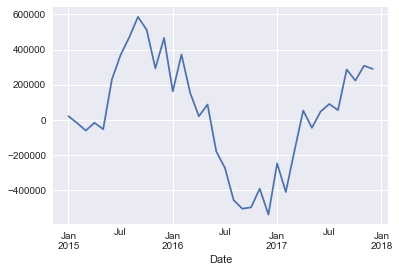

In [11]:
from statsmodels.tsa.stattools import adfuller

# create a differenced ds
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)
 
ds = reduced_dataset
X = ds.values
X = X.astype('float32')
# difference data
months_in_year = 12
stationary = difference(X, months_in_year)
stationary.index = ds.index[months_in_year:]
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# plot
stationary.plot()
plt.show()

The results show that the test statistic value -3.208282 is smaller than the critical value at 5% of -2.968. This suggests that we can reject the null hypothesis with a significance level of less than 5%. 

We reject the null hypothesis that the series is not stationary and claim the alternative that it is stationary or does not have time-dependent structure. 

The plot clearly shows no seasonality or trend. suggesting the seasonally differenced dataset is a good starting point for modeling. We will use this dataset as an input to the ARIMA model. It also suggests that no further differencing may be required, and that the d parameter may be set to 0

In [12]:
#FUNCTION DEFINITIONS

import warnings


# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    '''This is function to reverse the differencing to get the original time series '''
    return yhat + history[-interval]

# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.75)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        # difference data
        months_in_year = 12
        diff = difference(history, months_in_year)
        model = ARIMA(diff, order=arima_order)
        model_fit = model.fit(trend='nc', disp=0)
        yhat = model_fit.forecast()[0]
        yhat = inverse_difference(history, yhat, months_in_year)
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    mse = mean_squared_error(test, predictions)
    rmse = sqrt(mse)
    return rmse

# evaluate combinations of p, d and q values for an ARIMA model (Hypeparameter Tuning)

def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s RMSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))



**Hyperparameter tuning $(p,d,q)$ **

In [13]:
#We used grid search technique applied in the function evaluate_models to determine the best hyperparameters 
#(p,d & q) for the Arima model

# load dataset
series = reduced_dataset
# evaluate parameters. p and q range from 0-6 while d ranges from 0-2
p_values = range(0, 7)
d_values = range(0, 3)
q_values = range(0, 7)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 1) RMSE=176715.312
ARIMA(0, 0, 2) RMSE=154134.801
ARIMA(0, 1, 1) RMSE=153774.357
ARIMA(0, 1, 2) RMSE=131968.388
ARIMA(0, 1, 3) RMSE=151724.918
ARIMA(0, 2, 1) RMSE=163022.663
ARIMA(1, 0, 0) RMSE=147474.555
ARIMA(1, 0, 1) RMSE=144783.848
ARIMA(1, 0, 2) RMSE=115516.592
ARIMA(1, 0, 3) RMSE=151316.670
ARIMA(1, 1, 0) RMSE=150941.263
ARIMA(1, 2, 0) RMSE=175838.561
ARIMA(1, 2, 1) RMSE=149155.371
ARIMA(1, 2, 2) RMSE=151142.707
ARIMA(2, 0, 0) RMSE=142956.671
ARIMA(2, 0, 1) RMSE=142924.275
ARIMA(2, 0, 2) RMSE=138858.046
ARIMA(2, 1, 0) RMSE=149306.167
ARIMA(2, 1, 1) RMSE=142318.294
ARIMA(2, 2, 0) RMSE=135387.738
ARIMA(2, 2, 1) RMSE=137041.983
ARIMA(3, 0, 0) RMSE=140175.384
ARIMA(3, 0, 2) RMSE=109681.338
ARIMA(3, 1, 0) RMSE=130418.947
ARIMA(3, 2, 0) RMSE=137650.629
ARIMA(3, 2, 1) RMSE=138385.060
ARIMA(3, 2, 2) RMSE=144995.899
ARIMA(4, 0, 0) RMSE=111325.047
ARIMA(4, 0, 1) RMSE=112626.271
ARIMA(4, 0, 2) RMSE=135771.483
ARIMA(4, 1, 0) RMSE=130890.913
ARIMA(4, 1, 1) RMSE=125611.932
ARIMA(4,

                   0
count      12.000000
mean    54396.846787
std     99476.697649
min    -72876.932260
25%     -4378.227423
50%     41685.485194
75%     95578.695404
max    259113.460964


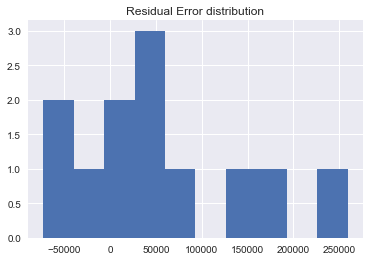

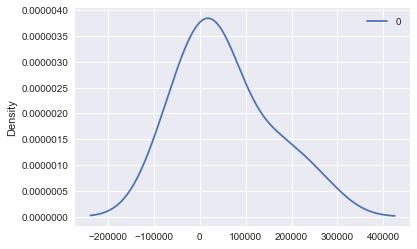

In [14]:
# REVIEW RESIDUAL ERRORS to determine if their distribution is normal and has a mean of zero. 

# load data
series = reduced_dataset
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.75)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # difference data
    months_in_year = 12
    diff = difference(history, months_in_year)
    # predict
    model = ARIMA(diff, order=(3,0,2))
    model_fit = model.fit(trend='nc', disp=0)
    yhat = model_fit.forecast()[0]
    yhat = inverse_difference(history, yhat, months_in_year)
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = pd.DataFrame(residuals)
print(residuals.describe())
# plot

residuals.hist(ax=plt.gca())
plt.title('Residual Error distribution')
plt.show()

residuals.plot(kind='kde', ax=plt.gca())
plt.show()


We see from the plot that the residual errors are approximately normal but are not centered on zero.

RMSE: 95241.687
                  0
count  1.200000e+01
mean   4.008907e-07
std    9.947670e+04
min   -1.272738e+05
25%   -5.877507e+04
50%   -1.271136e+04
75%    4.118185e+04
max    2.047166e+05


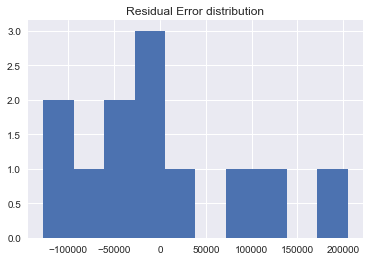

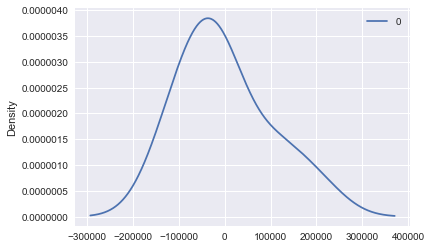

In [15]:
# TO SHIFT THE MEAN TO ZERO WE INTRODUCE A BIAS EQUIVALENT TO THE MEAN OF THE RESIDUAL ERRORS  

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# load data
series = reduced_dataset
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.750)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
bias = 54396.846787

for i in range(len(test)):
    # difference data
    months_in_year = 12
    diff = difference(history, months_in_year)
    # predict
    model = ARIMA(diff, order=(3,0,2))
    model_fit = model.fit(trend='nc', disp=0)
    yhat = model_fit.forecast()[0]
    yhat = bias + inverse_difference(history, yhat, months_in_year)
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = pd.DataFrame(residuals)
print(residuals.describe())
# plot
residuals.hist(ax=plt.gca())
plt.title('Residual Error distribution')
plt.show()
residuals.plot(kind='kde', ax=plt.gca())
plt.show()

Clearly the mean has moved closer to zero as the density plot shows.

In [16]:
#MAKE PREDICTION

# load data
series = reduced_dataset
# prepare data
X = series.values
X = X.astype('float32')
# difference data
months_in_year = 12
diff = difference(X, months_in_year)
# fit model
model = ARIMA(diff, order=(3,0,2))
model_fit = model.fit(trend='nc', disp=0)
# bias constant, could be calculated from in-sample mean residual
series = reduced_dataset
months_in_year = 12
yha = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(series.values, yha, months_in_year)
print(f'Predicted: {yhat:.3f} , First month of test data: {validation_dataset[0]:.3f}')

Predicted: 445130.901 , First month of test data: 439508.000


The model is very close in its prediction.

Predicted = 445130.901, Expected = 439508
Predicted = 502603.050, Expected = 438470
Predicted = 629047.660, Expected = 818048
Predicted = 795527.376, Expected = 744324
Predicted = 920468.506, Expected = 573164
Predicted = 661309.708, Expected = 634356
Predicted = 528069.175, Expected = 379933
Predicted = 310283.522, Expected = 311773
Predicted = 642599.615, Expected = 628897
Predicted = 406589.577, Expected = 414029
Predicted = 372906.515, Expected = 356277
Predicted = 393080.816, Expected = 527976
RMSE: 130542.906


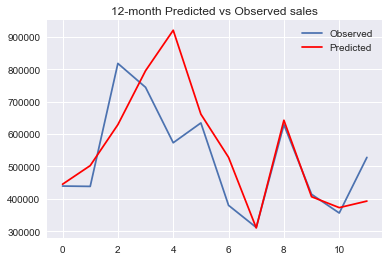

In [17]:
#VALIDATE MODEL

# load and prepare datasets
dataset = reduced_dataset
X = dataset.values.astype('float32')
history = [x for x in X]
months_in_year = 12
validation = validation_dataset
y = validation.values.astype('float32')
# make first prediction
predictions = list()
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(history, yhat, months_in_year)
predictions.append(yhat)
history.append(y[0])
print('Predicted = %.3f, Expected = %3.f' % (yhat, y[0]))
# rolling forecasts
for i in range(1, len(y)):
    # difference data
    months_in_year = 12
    diff = difference(history, months_in_year)
    # predict
    model = ARIMA(diff, order=(3,0,2))
    model_fit = model.fit(trend='nc', disp=0)
    yhat = model_fit.forecast()[0]
    yhat = bias + inverse_difference(history, yhat, months_in_year)
    predictions.append(yhat)
    # observation
    obs = y[i]
    history.append(obs)
    print('Predicted = %.3f, Expected = %3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(y, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)
plt.plot(y, label='Observed')
plt.plot(predictions, color='red', label='Predicted')
plt.title('12-month Predicted vs Observed sales')
plt.legend(loc='best')
plt.show()

In [18]:
from collections import OrderedDict
pred=OrderedDict({'Expected Values':y, 'Predicted Values': predictions, 'Forecast Error': predictions - y})

In [19]:
pred_df = pd.DataFrame(pred, index=pd.date_range('2018', periods=12, freq='MS')).round(2)
pred_df

,Expected Values,Predicted Values,Forecast Error
2018-01-01,439508.0,445130.90,5622.90
2018-02-01,438470.0,502603.05,64133.05
2018-03-01,818048.0,629047.66,-189000.34
2018-04-01,744324.0,795527.38,51203.38
2018-05-01,573164.0,920468.51,347304.51
2018-06-01,634356.0,661309.71,26953.71
2018-07-01,379933.0,528069.18,148136.18
2018-08-01,311773.0,310283.52,-1489.48
2018-09-01,628897.0,642599.62,13702.62
2018-10-01,414029.0,406589.58,-7439.42


In [20]:
# MODEL PERFORMANCE MEASURES

from sklearn.metrics import mean_absolute_error

# Mean absolute Error
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Mean Forecast Error or Forecast Bias
def mean_forecast_error(y_true,y_pred):
    forecast_error = [y_pred[i]-y_true[i] for i in range(len(y_pred))]
    return sum(forecast_error)/len(y)

def root_mean_square_error(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

In [21]:
# Calculate the different errors

func = [('Forecast Bias', mean_forecast_error), ('MAE', mean_absolute_error), 
        ('MAPE',mean_absolute_percentage_error), ('RMSE',root_mean_square_error)]
d = OrderedDict()

for i in func:
    d[i[0]] = i[1](y, predictions)
    
PM = pd.DataFrame(d, index=range(len(func))).drop_duplicates()
PM = PM.melt(var_name= 'Performance Measures', value_name = 'Value' ).round(3)
PM

,Performance Measures,Value
0,Forecast Bias,28405.118
1,MAE,83875.856
2,MAPE,15.366
3,RMSE,130542.906
